# Demo

This notebook is provided to describe the usage of pydpac using a one-dimensional toy model known as [the Lorenz (1996) model](https://doi.org/10.1175/1520-0469(1998)055%3C0399:OSFSWO%3E2.0.CO;2) described by the following equation.
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$

## Available DA algorithms

A data assimilation (DA) algorithm can be chosen from the followings.

文献のリンクをdoiで貼ってください。

- Kalman Filter
- 3DVar
- Ensemble Kalman Filter
 * ETKF
 * PO
 * EnSRF
 * LETKF
- Maximum Likelihoon Ensemble Filter ([Zupanski 2005](https://doi.org/10.1175/MWR2946.1), [Zupanski et al. 2008](https://doi.org/10.1002/qj.251))

## Requirements

- numpy for the model and DA
- pandas for error statistics
- matplotlib for plots

## Usage

Execute the cells below sequentially.

In [11]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

In [3]:
# model parameter
model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)

# forecast model forward operator
step = L96(nx, dt, F)

In [4]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [5]:
# DA experiment parameters (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
lloc = True # localization switch (True=Apply, False=Not apply)
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [6]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# specify assimilation method
from analysis.mlef import Mlef
analysis = Mlef(pt, obs, 1.1, model)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, obs, 1.1, 4.0, model)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, 1.1, step)
#from analysis.var import Var
#analysis = Var(pt, obs, model)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, model, step, nt, a_window)

2020-11-26 15:34:17,470 anl INFO model : l96
2020-11-26 15:34:17,471 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.1


In [7]:
# load functions
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, \
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm}
func = L96_func(params)

以下のコードのコメントを加えてください。

In [9]:
xt, yobs = func.get_true_and_obs()
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
    
a_time = range(0, na, a_window)
e = np.zeros(na)
chi = np.zeros(na)
ncycle = 1
for i in a_time:
    y = yobs[i:i+a_window]
    if a_window > 1:
        u, pa, chi2 = analysis(u, pf, y, \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)
    else:
        u, pa, chi2 = analysis(u, pf, y[0], \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)

    xa[i] = u
    sqrtpa[i] = pa
    chi[i] = chi2
    if i < na-1:
        if a_window > 1:
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
            xf[i+1] = u
    if a_window > 1:
        if ft == "deterministic":
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
        else:
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :, 0] - xt[k, :])**2))
    else:
        if ft == "deterministic":
            e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
        else:
            e[i] = np.sqrt(np.mean((xa[i, :, 0] - xt[i, :])**2))
    ncycle += 1


2020-11-26 15:34:36,896 anl INFO save_dh=False
2020-11-26 15:34:36,904 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2020-11-26 15:34:36,905 anl INFO save_hist=False
2020-11-26 15:34:37,027 anl INFO success=False message=Desired error not necessarily achieved due to precision loss.
2020-11-26 15:34:37,027 anl INFO J=1.237e+02 dJ=1.137e-04 nit=99
2020-11-26 15:34:37,034 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2020-11-26 15:34:37,035 anl INFO ==inflation==
2020-11-26 15:34:37,040 anl INFO save_dh=False
2020

2020-11-26 15:34:37,388 anl INFO singular value =[0.92124087 0.87917485 0.86507927 0.82177343 0.78804453 0.63842966
 0.62361719 0.60643331 0.57573479 0.56285502 0.52623236 0.47704141
 0.44491916 0.4366985  0.42191369 0.39905883 0.36615675 0.34651794
 0.27920189 0.2614249 ]
2020-11-26 15:34:37,390 anl INFO ==inflation==
2020-11-26 15:34:37,396 anl INFO save_dh=False
2020-11-26 15:34:37,403 anl INFO singular value =[0.90839997 0.85309136 0.83263547 0.82312699 0.7561446  0.66106934
 0.63906097 0.58901967 0.57638573 0.5484145  0.51306322 0.46017925
 0.43125398 0.41939587 0.38415181 0.38177058 0.35188538 0.33032561
 0.25552308 0.24841228]
2020-11-26 15:34:37,403 anl INFO save_hist=False
2020-11-26 15:34:37,409 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:37,410 anl INFO J=1.246e+02 dJ=1.079e-06 nit=7
2020-11-26 15:34:37,420 anl INFO singular value =[0.90839997 0.85309136 0.83263547 0.82312699 0.7561446  0.66106934
 0.63906097 0.58901967 0.57638573 0.5

2020-11-26 15:34:37,695 anl INFO save_hist=False
2020-11-26 15:34:37,701 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:37,702 anl INFO J=6.587e+01 dJ=1.786e-06 nit=8
2020-11-26 15:34:37,708 anl INFO singular value =[1.02826314 0.91153825 0.85250955 0.81186235 0.7304067  0.6809499
 0.6382011  0.61138335 0.58306798 0.49713365 0.43201925 0.40136324
 0.37069853 0.35141941 0.31051477 0.28524937 0.2501581  0.21510134
 0.18802172 0.1677697 ]
2020-11-26 15:34:37,708 anl INFO ==inflation==
2020-11-26 15:34:37,716 anl INFO save_dh=False
2020-11-26 15:34:37,726 anl INFO singular value =[1.01539696 0.94233989 0.83521673 0.75949223 0.71476526 0.65932509
 0.64265875 0.60686058 0.52605794 0.4858201  0.4676178  0.41410829
 0.38615867 0.35655979 0.30903186 0.27076269 0.25505742 0.21900508
 0.19105306 0.16087438]
2020-11-26 15:34:37,727 anl INFO save_hist=False
2020-11-26 15:34:37,734 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15

2020-11-26 15:34:38,005 anl INFO singular value =[0.89400612 0.855592   0.76192444 0.67287016 0.63083773 0.60652831
 0.58727609 0.55726495 0.51773748 0.49462852 0.47345051 0.42196253
 0.40342602 0.38820009 0.35054824 0.33832801 0.26252105 0.22148757
 0.20059934 0.16072038]
2020-11-26 15:34:38,007 anl INFO save_hist=False
2020-11-26 15:34:38,011 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:38,012 anl INFO J=2.748e+01 dJ=1.619e-06 nit=7
2020-11-26 15:34:38,021 anl INFO singular value =[0.89400612 0.855592   0.76192444 0.67287016 0.63083773 0.60652831
 0.58727609 0.55726495 0.51773748 0.49462852 0.47345051 0.42196253
 0.40342602 0.38820009 0.35054824 0.33832801 0.26252105 0.22148757
 0.20059934 0.16072038]
2020-11-26 15:34:38,023 anl INFO ==inflation==
2020-11-26 15:34:38,027 anl INFO save_dh=False
2020-11-26 15:34:38,036 anl INFO singular value =[0.9485111  0.83009649 0.79086405 0.68222503 0.67482153 0.65496137
 0.61806328 0.5371078  0.52579139 0.5

2020-11-26 15:34:38,303 anl INFO ==inflation==
2020-11-26 15:34:38,309 anl INFO save_dh=False
2020-11-26 15:34:38,316 anl INFO singular value =[1.05815256 0.92572726 0.86073324 0.84351099 0.77236898 0.65598875
 0.57799394 0.55111937 0.50032118 0.48961902 0.44558001 0.40493181
 0.39605317 0.37688185 0.33011975 0.23964784 0.21167102 0.18202132
 0.17432387 0.1449734 ]
2020-11-26 15:34:38,317 anl INFO save_hist=False
2020-11-26 15:34:38,322 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:38,322 anl INFO J=2.297e+01 dJ=2.175e-07 nit=8
2020-11-26 15:34:38,329 anl INFO singular value =[1.05815256 0.92572726 0.86073324 0.84351099 0.77236898 0.65598875
 0.57799394 0.55111937 0.50032118 0.48961902 0.44558001 0.40493181
 0.39605317 0.37688185 0.33011975 0.23964784 0.21167102 0.18202132
 0.17432387 0.1449734 ]
2020-11-26 15:34:38,332 anl INFO ==inflation==
2020-11-26 15:34:38,337 anl INFO save_dh=False
2020-11-26 15:34:38,346 anl INFO singular value =[1.0558066

2020-11-26 15:34:38,602 anl INFO singular value =[1.00821404 0.84291337 0.79966786 0.76013359 0.6816429  0.65479392
 0.61333067 0.58518693 0.56617335 0.52546579 0.46768476 0.43161313
 0.39372674 0.37495024 0.32130163 0.29467012 0.24679326 0.22509976
 0.17313937 0.10879768]
2020-11-26 15:34:38,605 anl INFO ==inflation==
2020-11-26 15:34:38,609 anl INFO save_dh=False
2020-11-26 15:34:38,618 anl INFO singular value =[0.97261263 0.8849403  0.78341883 0.77464861 0.73087333 0.63961977
 0.60912005 0.58659872 0.54070998 0.50674319 0.45355904 0.4375827
 0.39401031 0.35546402 0.32795198 0.29308904 0.25579562 0.22920265
 0.18108185 0.12371392]
2020-11-26 15:34:38,619 anl INFO save_hist=False
2020-11-26 15:34:38,626 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:38,627 anl INFO J=2.182e+01 dJ=1.774e-06 nit=7
2020-11-26 15:34:38,636 anl INFO singular value =[0.97261263 0.8849403  0.78341883 0.77464861 0.73087333 0.63961977
 0.60912005 0.58659872 0.54070998 0.50

2020-11-26 15:34:38,901 anl INFO save_hist=False
2020-11-26 15:34:38,907 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:38,908 anl INFO J=2.352e+01 dJ=5.168e-07 nit=7
2020-11-26 15:34:38,917 anl INFO singular value =[0.90613072 0.87501643 0.74447634 0.7103689  0.63139082 0.62019954
 0.58554282 0.54992031 0.53525365 0.49618165 0.45640587 0.44057675
 0.40429853 0.38255907 0.37147763 0.33912388 0.25200553 0.23671926
 0.19218879 0.13784448]
2020-11-26 15:34:38,918 anl INFO ==inflation==
2020-11-26 15:34:38,923 anl INFO save_dh=False
2020-11-26 15:34:38,931 anl INFO singular value =[0.94173886 0.89603795 0.81515207 0.72647808 0.66299076 0.61152704
 0.58906946 0.54639977 0.50302715 0.49253302 0.46431686 0.43449753
 0.41769799 0.39075279 0.3669071  0.33189624 0.25991591 0.21982818
 0.18363258 0.12102906]
2020-11-26 15:34:38,933 anl INFO save_hist=False
2020-11-26 15:34:38,940 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 1

2020-11-26 15:34:39,190 anl INFO save_hist=False
2020-11-26 15:34:39,194 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:39,194 anl INFO J=2.420e+01 dJ=6.951e-07 nit=7
2020-11-26 15:34:39,203 anl INFO singular value =[0.86485424 0.8327458  0.76563913 0.6880583  0.67303063 0.6155487
 0.57449931 0.51298311 0.49857068 0.48849755 0.46711741 0.42574807
 0.3953685  0.38740477 0.3165766  0.27993097 0.20864159 0.19610348
 0.17479462 0.1509984 ]
2020-11-26 15:34:39,205 anl INFO ==inflation==
2020-11-26 15:34:39,211 anl INFO save_dh=False
2020-11-26 15:34:39,219 anl INFO singular value =[0.88147199 0.83455714 0.829931   0.62935572 0.60204432 0.58201035
 0.5557445  0.54740236 0.53136032 0.50272774 0.48636018 0.4359405
 0.39585539 0.38751956 0.33632222 0.28612591 0.21398739 0.18622561
 0.17152794 0.15310059]
2020-11-26 15:34:39,221 anl INFO save_hist=False
2020-11-26 15:34:39,227 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:

2020-11-26 15:34:39,484 anl INFO save_hist=False
2020-11-26 15:34:39,489 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:39,489 anl INFO J=2.878e+01 dJ=1.392e-06 nit=6
2020-11-26 15:34:39,497 anl INFO singular value =[0.82184236 0.78232386 0.74843266 0.71080715 0.70672438 0.56722795
 0.50079405 0.49156911 0.45635118 0.4431468  0.42747258 0.39630874
 0.36445408 0.34300795 0.31491707 0.27633709 0.23439108 0.22227153
 0.21038795 0.16515098]
2020-11-26 15:34:39,498 anl INFO ==inflation==
2020-11-26 15:34:39,504 anl INFO save_dh=False
2020-11-26 15:34:39,513 anl INFO singular value =[0.82535538 0.79112677 0.74353794 0.6966221  0.68543818 0.58577665
 0.52312281 0.50778359 0.49966162 0.46273122 0.39866066 0.37828614
 0.36125054 0.32769491 0.29084718 0.26790975 0.22742302 0.21180807
 0.19849964 0.15888554]
2020-11-26 15:34:39,514 anl INFO save_hist=False
2020-11-26 15:34:39,522 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 1

2020-11-26 15:34:39,911 anl INFO singular value =[0.81081751 0.79529595 0.73753769 0.67163132 0.66218162 0.60456305
 0.57398735 0.49950138 0.48925801 0.46238717 0.45581957 0.43616736
 0.39162102 0.34863384 0.30729657 0.28860146 0.26598284 0.2271082
 0.20558415 0.18337305]
2020-11-26 15:34:39,912 anl INFO save_hist=False
2020-11-26 15:34:39,916 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:39,916 anl INFO J=3.129e+01 dJ=1.702e-06 nit=6
2020-11-26 15:34:39,924 anl INFO singular value =[0.81081751 0.79529595 0.73753769 0.67163132 0.66218162 0.60456305
 0.57398735 0.49950138 0.48925801 0.46238717 0.45581957 0.43616736
 0.39162102 0.34863384 0.30729657 0.28860146 0.26598284 0.2271082
 0.20558415 0.18337305]
2020-11-26 15:34:39,926 anl INFO ==inflation==
2020-11-26 15:34:39,930 anl INFO save_dh=False
2020-11-26 15:34:39,938 anl INFO singular value =[0.78602791 0.77614911 0.76026718 0.69633548 0.67416205 0.60324989
 0.59104736 0.52419356 0.4727657  0.471

2020-11-26 15:34:40,218 anl INFO ==inflation==
2020-11-26 15:34:40,222 anl INFO save_dh=False
2020-11-26 15:34:40,230 anl INFO singular value =[0.86676441 0.79436719 0.73166864 0.6860677  0.65236934 0.58675721
 0.57075657 0.53237359 0.51511558 0.49196838 0.47430899 0.41799465
 0.38655452 0.3687146  0.30119221 0.27308303 0.27028239 0.22812782
 0.18289974 0.15591611]
2020-11-26 15:34:40,231 anl INFO save_hist=False
2020-11-26 15:34:40,235 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 15:34:40,236 anl INFO J=1.796e+01 dJ=6.560e-07 nit=7
2020-11-26 15:34:40,243 anl INFO singular value =[0.86676441 0.79436719 0.73166864 0.6860677  0.65236934 0.58675721
 0.57075657 0.53237359 0.51511558 0.49196838 0.47430899 0.41799465
 0.38655452 0.3687146  0.30119221 0.27308303 0.27028239 0.22812782
 0.18289974 0.15591611]
2020-11-26 15:34:40,244 anl INFO ==inflation==
2020-11-26 15:34:40,248 anl INFO save_dh=False
2020-11-26 15:34:40,257 anl INFO singular value =[0.8365928

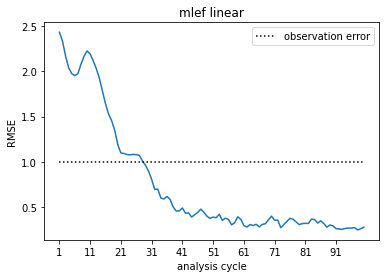

In [10]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()